# Stepik: https://stepik.org/users/187038691

# Face Recognition Project

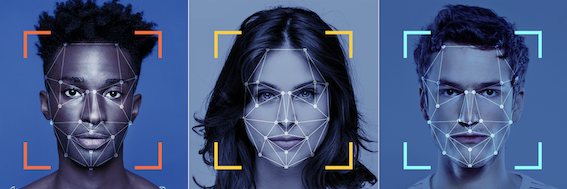

In this project you'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.

This basic notebook will give you 8/10 points, if completed fully. There are also additional features you might implement to get additional points. You may do additional tasks and receive additional points even if you didn't fully complete the basic notebook. This means you can choose which tasks to do. **Additional features that you might implement are listed in Telegram chat**.

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

As you see on the site, images of celebA dataset look like this:


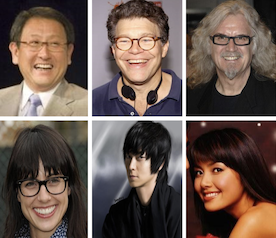

But we won't train a neural network for face recognition on those images. We'll need to preprocess them first. Let's see why we need it and how we need to preprocess them.

Let's look at how face recognition systems work:

## Face recognition model training and inference setup

This section describes how face recognition models are trained, what data alignment is and how the inference of face recognition model looks like. If you are familiar with this, you can skip this section.

### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

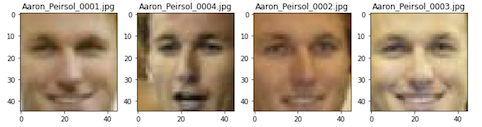

You see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model diesn't need to "search" for the face and eyes positions on the image befire performing a recognition.

If you are interested, you can also train a model on non-aligned images, but you'll see that it would perform badly. It is possible though to train a model for face recognition without pre-alignment of all the faces, but this would require a huge amount of data — more that almost any company has. The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

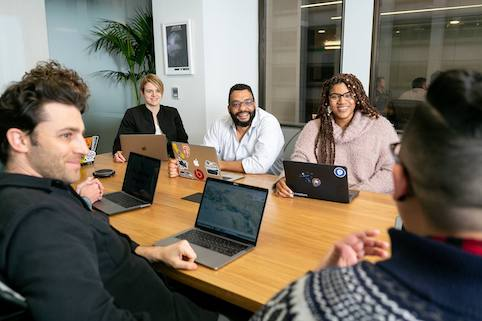

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

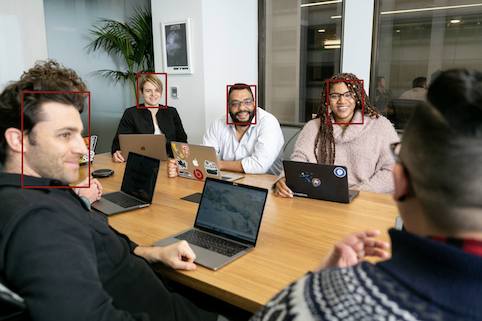

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

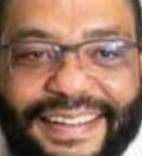

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural network model architecture

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is.

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people.

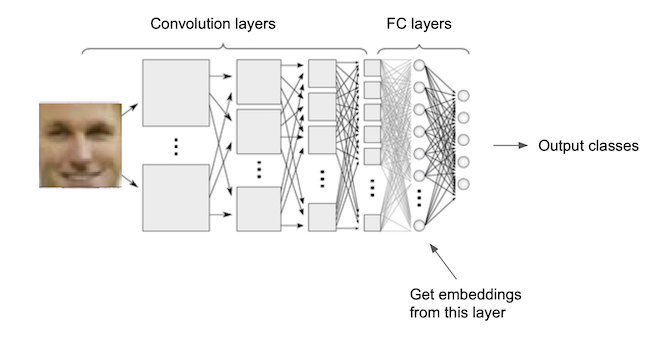

## Task 1 (2 points): build a neural network for faces classification as discribed above.

### Dataset

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw or using the code below:

In [13]:
#!pip install wldhx.yadisk-direct
#!curl -L $(yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw) -o celebA_train_500.zip
!unzip -qq celebA_train_500.zip

Let's look at the data first:

In [14]:
! ls celebA_train_500/

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder with aligned images
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [15]:
import os
import cv2
import math
import numpy as np
from PIL import Image
from skimage import io, transform
from tqdm import tqdm, tqdm_notebook

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import seaborn as sb
import torchvision.utils

Let's visualize some images to understand what we're dealing with:

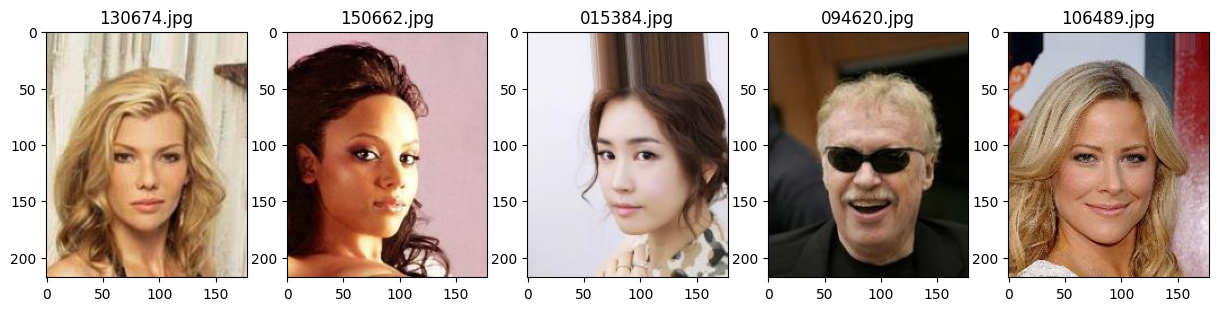

In [16]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_500/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_train_500/celebA_imgs/')[:5]
show_imgs(images_names)


### Train Neural Network

Let's build a Datasets and network using this images:

In [17]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))

    return np.array(images_paths)


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_name)

        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }

        sample['image'] = self.transform(sample['image'])
        sample['label'] = int(sample['label'])

        return sample

In [18]:
transform = transforms.Compose([
      # you may add anything, e.g. augmentation
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = celebADataset('train', transform)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

# choose your own batch_size
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

**Workflow**: train a model on train_data using val_data for validation.Use standard CE loss.  Calculate the loss and accuracy on test set after training.

You may use whatever model you want, including pre-trained on ImageNet models from torchvision. Please note, that **it is not allowed to use pre-trained models on any other dataset except ImageNet**.

To get higher score, try to adjust hyperparameters, maybe try augmentations, etc.

Hints: Do not use too big model. Small ResNet-like network is enough to get the required score. Use at least 2 linear layers on the bottom. You'll need to drop the last layer after training and get image embeddings from the pre-last layer. It's not required to get the embedding from linear layer though: you may get it from last convolution layer, if you want.

**To get the whole mark for this section you need to achieve 70% accuracy on test set**.

In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for batch in train_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs).to(DEVICE)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [21]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for batch in val_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs).to(DEVICE)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [22]:
def train(train_loader, val_loader, model, epochs, optimizer, criterion):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

def test_accuracy(test_loader, model):
    model.eval()
    running_corrects = 0
    processed_size = 0
    for batch in test_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs).to(DEVICE)
            preds = torch.argmax(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    test_acc = running_corrects.double() / processed_size
    return test_acc.item()

In [23]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.6 MB/s eta 0:00:00


In [24]:
from facenet_pytorch import InceptionResnetV1
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 1000)
all_layers = []
for name, param in model.named_parameters():
    good_name = name.strip().split(".")
    if good_name[0] not in all_layers:
        all_layers.append(good_name[0])

for name, param in model.named_parameters():
    good_name = name.strip().split(".")
    if good_name[0] not in all_layers[-3:]:
        param.requires_grad = False

model.logits = torch.nn.Linear(in_features=512, out_features = 1000, bias=True)

model = model.to(DEVICE)
#model.load_state_dict(torch.load("model_weights.pth", map_location = DEVICE))

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [25]:
opt = torch.optim.AdamW(model.parameters(), amsgrad = True)
criterion = torch.nn.CrossEntropyLoss()
history = train(train_loader, val_loader, model= model, epochs=5, optimizer = opt, criterion= criterion)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.7941611384631098


epoch:  20%|██        | 1/5 [00:57<03:50, 57.72s/it]


Epoch 001 train_loss: 2.7942     val_loss 0.6819 train_acc 0.6286 val_acc 0.9116
loss 0.4775267564290472


epoch:  40%|████      | 2/5 [01:38<02:22, 47.51s/it]


Epoch 002 train_loss: 0.4775     val_loss 0.4034 train_acc 0.9355 val_acc 0.9356
loss 0.2994446541262923


epoch:  60%|██████    | 3/5 [02:18<01:28, 44.14s/it]


Epoch 003 train_loss: 0.2994     val_loss 0.3692 train_acc 0.9552 val_acc 0.9329
loss 0.19659004419037465


epoch:  80%|████████  | 4/5 [02:57<00:42, 42.39s/it]


Epoch 004 train_loss: 0.1966     val_loss 0.3584 train_acc 0.9717 val_acc 0.9249
loss 0.1538589055116257


epoch: 100%|██████████| 5/5 [03:38<00:00, 43.72s/it]


Epoch 005 train_loss: 0.1539     val_loss 0.3345 train_acc 0.9757 val_acc 0.9260


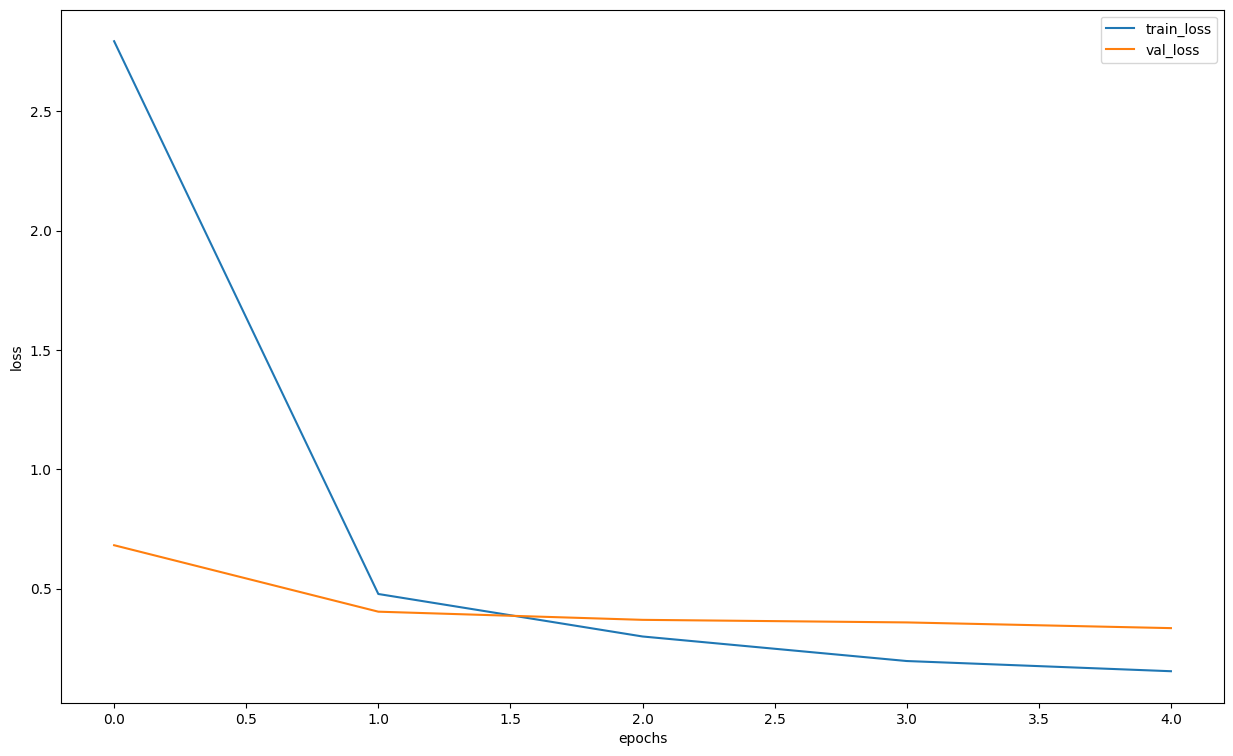

In [26]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label = "train_loss")
plt.plot(val_loss, label = "val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [27]:
import copy

# lets save weights of our model
torch.save(model.state_dict(), "model_weights.pth")

#model_weights = copy.deepcopy(model.state_dict())
#torch.save(model_weights, "model_weights.pth")

In [28]:
test_acc = test_accuracy(test_loader, model)
print("Test accuracy: ", test_acc)

Test accuracy:  0.9301447451227187


**Cosine similarity calculation**: drop the last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [29]:
def cosine_similarity(tensor1, tensor2):
    norm1 = torch.sqrt(torch.sum(tensor1 * tensor1))
    norm2 = torch.sqrt(torch.sum(tensor2 * tensor2))
    skal = torch.sum(tensor1 * tensor2)
    return (skal / (norm1 * norm2)).item()

In [30]:
def cosine_similarity_tns_grp(group, group_norm, tensor):
    tensor_norm = torch.sqrt(torch.sum(tensor * tensor))
    skal = torch.sum(group * tensor, 1)
    return (skal / (group_norm * tensor_norm.item()))

In [31]:
# Drop a last layer
model.last_bn = torch.nn.Identity()
model.logits = torch.nn.Identity()
model = model.to(DEVICE)

In [32]:
train_loader_1sz = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
test_loader_1sz = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

train_paths = get_paths('train')
test_paths = get_paths('test')

In [33]:
def build_plt(train_vals, test_vals):
    sz = min(5, min(len(train_vals), len(test_vals)))
    res_cs = []
    for i in range(sz):
        res1 = model(train_vals[i][1]["image"].to(DEVICE))
        res2 = model(test_vals[i][1]["image"].to(DEVICE))
        res_cs.append(cosine_similarity(res1, res2))

    f, axes= plt.subplots(2, sz, figsize=(3*sz, 7))
    for i in range(sz):
        image = Image.open(train_paths[train_vals[i][0]])
        axes[0][i].imshow(image, cmap='gray')
        image = Image.open(test_paths[test_vals[i][0]])
        axes[1][i].imshow(image, cmap = 'gray')
        axes[1][i].set_title("Cos sim = " + f"{res_cs[i]:.4f}")

    for i, ax in enumerate(axes.flat):
        if i == 0:
            ax.set(ylabel = 'Train data')
        if i == sz:
            ax.set(ylabel = 'Test data')

    plt.suptitle("Images of person #" + str(person_id))
    plt.show()

Cosine similarity calculation for images of same person from train and test datasets:

FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK


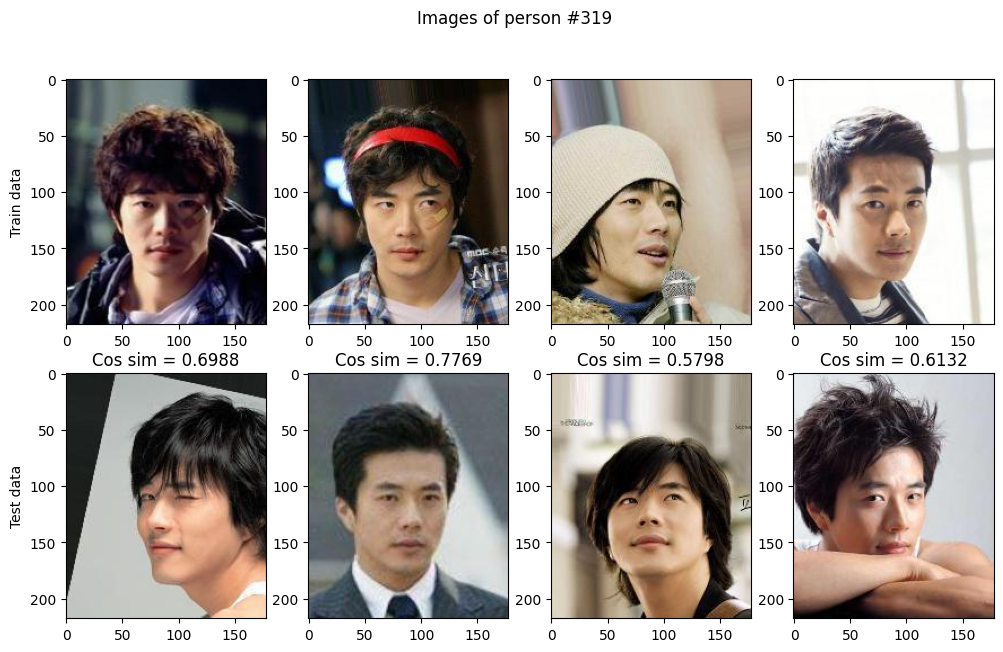

In [37]:
person_id = torch.randint(0, 1000, (1, 1)).item()

train_vals = []
test_vals = []
for i, train in enumerate(train_loader_1sz):
  if person_id == train['label'].item():
    print("FUCK")
    train_vals.append((i, train))
for i, test in enumerate(test_loader_1sz):
  if person_id == test['label'].item():
    test_vals.append((i, test))
build_plt(train_vals, test_vals)


Cosine similarity calculation for images of one person from train set with different persons from test set:

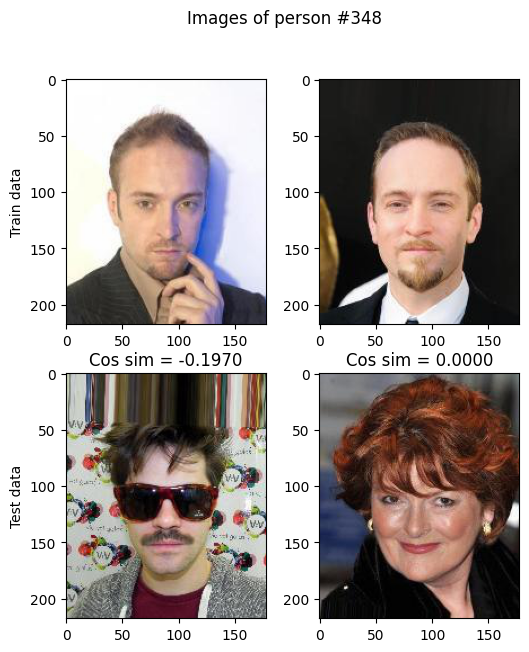

In [38]:
def rand_without_num(num):
  if torch.randint(0, 2, (1, 1)).item() == 0:
    return torch.randint(0, num, (1, 1)).item()
  return torch.randint(num+1, 1000, (1, 1)).item()

person_id = torch.randint(0, 1000, (1, 1)).item()
persons_id = [rand_without_num(person_id) for i in range(5)]

train_vals = []
test_vals = []
for i, train in enumerate(train_loader_1sz):
  if person_id == train['label'].item():
    train_vals.append((i, train))

for i, test in enumerate(test_loader_1sz):
  if test['label'].item() in persons_id:
    test_vals.append((i, test))
    persons_id.remove(test['label'].item())

build_plt(train_vals, test_vals)

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset.

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset.

Visualize (build histograms) the cosine similarities distributions for same and different people.

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between. For example, use 1000-5000 examples.

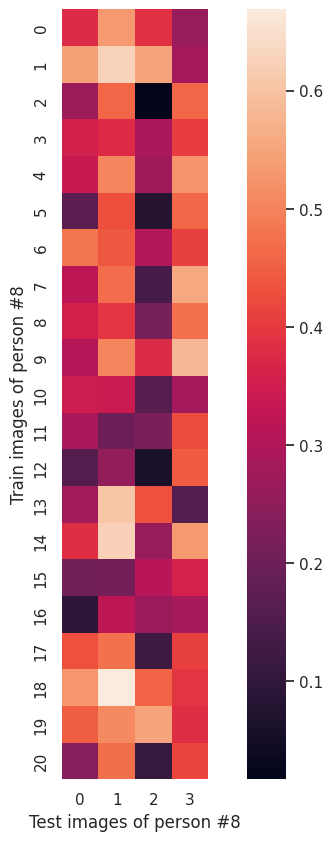

In [39]:
# Same person from test and train datasets
sb.set(rc = {'figure.figsize':(10,10)})

person_id = torch.randint(0, 1000, (1, 1)).item()

train_vals = []
test_vals = []
for i, train in enumerate(train_loader_1sz):
    if person_id == train['label'].item():
        train_vals.append((i, train))
for i, test in enumerate(test_loader_1sz):
    if person_id == test['label'].item():
        test_vals.append((i, test))

array = np.eye(len(train_vals), len(test_vals))
for i, train in enumerate(train_vals):
    for j, test in enumerate(test_vals):
        res1 = model(train[1]["image"].to(DEVICE))
        res2 = model(test[1]["image"].to(DEVICE))
        array[i][j] = cosine_similarity(res1, res2)

heat_map = sb.heatmap(array, square = True)
plt.xlabel("Test images of person #" + str(person_id))
plt.ylabel("Train images of person #" + str(person_id))
plt.show()

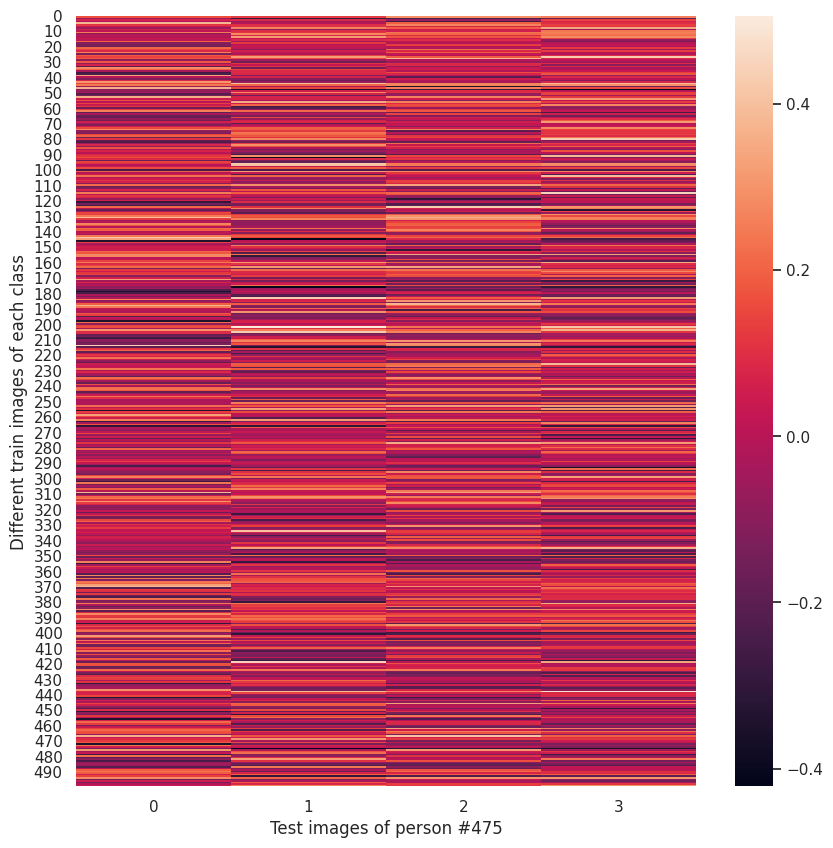

In [40]:
# Person from test vs different persons from train dataset (we take only 1 image for each class)

person_id1 = torch.randint(0, 1000, (1, 1)).item()
train_vals = []
test_vals = []

for test in test_loader_1sz:
    if person_id1 == test['label'].item():
        test_vals.append(test)

prev = -1
for train in train_loader_1sz:
    if person_id1 != train['label'].item() and train['label'].item() != prev:
        train_vals.append(train)
        prev = train['label'].item()

array = np.eye(len(train_vals), len(test_vals))
for i, train in enumerate(train_vals):
    for j, test in enumerate(test_vals):
        res1 = model(train["image"].to(DEVICE))
        res2 = model(test["image"].to(DEVICE))
        array[i][j] = cosine_similarity(res1, res2)

heat_map = sb.heatmap(array)
plt.xlabel("Test images of person #" + str(person_id1))
plt.ylabel("Different train images of each class")
plt.show()

## Task 2 (2 points): Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos.
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset.
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary.

Datasets (query photos, query labels & distructors photos) you can download using the code below:

In [41]:
! curl -L $(yadisk-direct https://disk.yandex.com/d/KN4EEkNKrF_ZXQ) -o celebA_ir.zip
! unzip -qq celebA_ir.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 8978k  100 8978k    0     0  2768k      0  0:00:03  0:00:03 --:--:-- 6305k


**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.


In [42]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

In [43]:
def compute_embeddings(model, images_type, images_list):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  # YOUR CODE HERE
  model.eval()
  path = './celebA_ir/celebA_query/' if images_type == 'query' else './celebA_ir/celebA_distractors/'
  res_list = []
  for img_name in images_list:
      image = Image.open(path + img_name)
      with torch.set_grad_enabled(False):
          image = transform(image).to(DEVICE)
          res_list.append(model(torch.unsqueeze(image, 0)).to(DEVICE))
  return res_list

In [44]:
query_embeddings = compute_embeddings(model, 'query', query_img_names)
distractors_embeddings = compute_embeddings(model, 'distractors', distractors_img_names)

In [45]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
  '''
  # YOUR CODE HERE
  result = []
  work_dict = dict(zip(query_img_names, query_embeddings))
  for key in query_dict.keys():
      for i in range(len(query_dict[key])):
          for j in range(i+1, len(query_dict[key])):
              tensor1 = work_dict[query_dict[key][i]]
              tensor2 = work_dict[query_dict[key][j]]
              result.append(cosine_similarity(tensor1, tensor2))
              if len(result) > 10:
                  return result
  return result

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  # YOUR CODE HERE
  result = []
  work_dict = dict(zip(query_img_names,query_embeddings))
  keys_list = list(query_dict.keys())
  for k1 in range(len(keys_list)):
      group_list = [work_dict[v] for v in query_dict[keys_list[k1]]]
      if len(group_list[0].shape) == 1:
          group_list = [torch.unsqueeze(v, 0) for v in group_list]
      group = torch.cat(group_list, 0)
      group_norm = torch.sqrt(torch.sum(group * group, 1))
      for k2 in range(k1+1, len(keys_list)):
          tensors = [work_dict[v] for v in query_dict[keys_list[k2]]]
          for tns in tensors:
              res = cosine_similarity_tns_grp(group, group_norm, tns)
              for val in res:
                  result.append(val.item())
                  if len(result) > 10:
                      return result
  return result

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  # YOUR CODE HERE
  result = []
  if len(query_embeddings[0].shape) == 1:
      query_embeddings = [torch.unsqueeze(v, 0) for v in query_embeddings]
  group = torch.cat(query_embeddings, 0)
  group_norm = torch.sqrt(torch.sum(group * group, 1))
  for val in distractors_embeddings:
      res = cosine_similarity_tns_grp(group, group_norm, val)
      for tns in res:
          result.append(tns.item())
  return result

In [46]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


Check you code of functions which compute similarities:

In [47]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    torch.FloatTensor([1.56, 6.45,  -7.68]),
                    torch.FloatTensor([-1.1 , 6.11,  -3.0]),
                    torch.FloatTensor([-0.06,-0.98,-1.29]),
                    torch.FloatTensor([8.56, 1.45,  1.11]),
                    torch.FloatTensor([0.7,  1.1,   -7.56]),
                    torch.FloatTensor([0.05, 0.9,   -2.56]),
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    torch.FloatTensor([0.12, -3.23, -5.55]),
                    torch.FloatTensor([-1,   -0.01, 1.22]),
                    torch.FloatTensor([0.06, -0.23, 1.34]),
                    torch.FloatTensor([-6.6, 1.45,  -1.45]),
                    torch.FloatTensor([0.89,  1.98, 1.45]),
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [48]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Implement the final function: identification rate calculation

In [49]:
def compute_ir(cosine_query_pos, cosine_query_neg = None, cosine_query_distractors = None,
               fpr=0.1, false_pairs = None):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  # YOUR CODE HERE
  if false_pairs == None:
      N = (len(cosine_query_neg) + len(cosine_query_distractors)) * fpr
      false_pairs = cosine_query_neg + cosine_query_distractors
      false_pairs.sort(reverse = True)
  else:
      N = len(false_pairs) * fpr
  counter = 0
  N = int(N)
  for val in cosine_query_pos:
      if val >= false_pairs[N]:
          counter += 1
  return (false_pairs[N], counter / len(cosine_query_pos) )

Check yourself:

In [50]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [51]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [52]:
# YOUR CODE HERE
fpr = [0.5, 0.2, 0.1, 0.05]
cosine_query_distractors.extend(cosine_query_neg)
cosine_query_distractors.sort(reverse = True)
for val in fpr:
    x, y = compute_ir(cosine_query_pos = cosine_query_pos, fpr = val, false_pairs = cosine_query_distractors)
    print("For fpr = ", val, ": TPR = ", y, " ; Threshold similarity = ", x)

For fpr =  0.5 : TPR =  1.0  ; Threshold similarity =  0.12346592545509338
For fpr =  0.2 : TPR =  0.9090909090909091  ; Threshold similarity =  0.2615160644054413
For fpr =  0.1 : TPR =  0.9090909090909091  ; Threshold similarity =  0.33345547318458557
For fpr =  0.05 : TPR =  0.9090909090909091  ; Threshold similarity =  0.39202070236206055


## Task 3 (4 points): Loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

### TripletLoss (2 points)

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other.

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo.

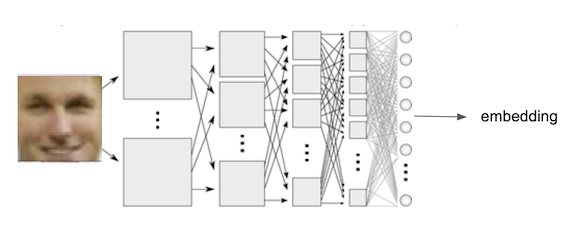

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results. Again, you might use whatever architecture you prefer, including ImageNet pre-trained networks. Do not use pre-trained networks on any other dataset.

Which loss among which you have tried is the best?

**To get the full mark for this task you need to train a model using  TripletLoss correctly at least for one value of margin and achieve >=70% acc on test set.**
As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embeddings from val and test sets calculate cosine similarities be

**Hints**:
- think of what the distance function $d$ should be in our case: training a model we want it to output embeddings which can be compared using cosine similarity function. Pay attention to that cosine similarity is not a distance measure — the more cosine distance, the closer embeddings are. Think how you can put cosine distance into TripletLoss function.
- to train model using this loss you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive images and negative images for this image;
- don't forget to normalize embeddings for the loss! You may even do that by adding batchnorm/layernorm to the last layer of your network

In [53]:
from torch.utils.data.sampler import Sampler
class MySampler(Sampler):
    def __init__(self, dataset):
        self.dataset = dataset

    def __iter__(self):
        self.result = []
        left = 0
        right = 0
        for idx in range(len(self.dataset)):
            if idx == 0 or self.dataset[idx]['label'] != self.dataset[idx-1]['label']:
                left = idx
                right = left
                while right != len(self.dataset) and self.dataset[right]['label'] == self.dataset[left]['label']:
                    right += 1
                right -= 1

            # calculation negative index
            if left == 0:
                negative_idx = torch.randint(right + 1, len(self.dataset), (1, 1)).item()
            elif right == len(self.dataset) - 1:
                negative_idx = torch.randint(0, left, (1, 1)).item()
            else:
                negative_idx = torch.randint(0, left, (1, 1)).item() if torch.randint(0, 2, (1, 1)).item() == 0 else torch.randint(right + 1, len(self.dataset), (1, 1)).item()

            # calculation positive index
            if left == right:
                positive_idx = left
            elif idx == left:
                positive_idx = torch.randint(left + 1, right + 1, (1, 1)).item()
            elif idx == right:
                positive_idx = torch.randint(left, right, (1, 1)).item()
            else:
                positive_idx = torch.randint(left, idx, (1, 1)).item() if torch.randint(0, 2, (1, 1)).item() == 0 else torch.randint(idx + 1, right + 1, (1, 1)).item()

            self.result.append(idx)
            self.result.append(int(positive_idx))
            self.result.append(int(negative_idx))
        return iter(self.result)

    def __len__(self):
        return len(self.dataset)

In [54]:
def my_collate_fn(data):
    anchors = { 'image' : torch.unsqueeze(data[0]['image'], 0), 'label' : torch.tensor([ [ data[0]['label'] ] ] ) }
    positives = { 'image' : torch.unsqueeze(data[1]['image'], 0), 'label' :  torch.tensor([ [ data[1]['label'] ] ] ) }
    negatives = { 'image' : torch.unsqueeze(data[2]['image'], 0), 'label' :  torch.tensor([ [ data[2]['label'] ] ] ) }
    for val in range(3, len(data), 3):
        anchors['image'] = torch.cat((anchors['image'], torch.unsqueeze(data[val]['image'], 0)), 0)
        anchors['label'] = torch.cat((anchors['label'], torch.tensor([ [ data[val]['label'] ] ] )), 0)

        positives['image'] = torch.cat((positives['image'], torch.unsqueeze(data[val+1]['image'], 0)), 0)
        positives['label'] = torch.cat((positives['label'],  torch.tensor([ [ data[val+1]['label'] ] ] ) ), 0)

        negatives['image'] = torch.cat((negatives['image'], torch.unsqueeze(data[val+2]['image'], 0)), 0)
        negatives['label'] = torch.cat((negatives['label'],  torch.tensor([ [ data[val+2]['label'] ] ] )), 0)

    return { "anchors" : anchors, "positives" : positives, "negatives" : negatives }

In [55]:
train_data = celebADataset('train', transform)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

# choose your own batch_size
batch_size = 64
class_cnt = 1000
train_loader = torch.utils.data.DataLoader(train_data, collate_fn= my_collate_fn, sampler = MySampler(train_data), batch_size = batch_size * 3)
val_loader = torch.utils.data.DataLoader(val_data, collate_fn= my_collate_fn, sampler = MySampler(val_data), batch_size= batch_size * 3)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [56]:
def calculate_preds(embeddings, mean_embeddings, prev_mean_emb_norm):
    result = torch.unsqueeze(torch.tensor([torch.argmax(cosine_similarity_tns_grp(mean_embeddings, prev_mean_emb_norm, val)).item() for val in embeddings]), 1)
    return result.to(DEVICE)

In [57]:
def fit_epoch(model, train_loader, criterion, optimizer, prev_mean_embeddings):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    with torch.set_grad_enabled(False):
        mean_embeddings = torch.zeros(class_cnt, 512).to(DEVICE)
        embeddings_cnt = [ 0 for i in range(class_cnt)]
        prev_mean_emb_norm = torch.sqrt(torch.sum(prev_mean_embeddings * prev_mean_embeddings, 1))

    for batch in train_loader:

        anchors = batch["anchors"]["image"].to(DEVICE)
        anchors_labels = batch["anchors"]["label"].to(DEVICE)
        positives = batch["positives"]["image"].to(DEVICE)
        negatives = batch["negatives"]["image"].to(DEVICE)

        optimizer.zero_grad()

        outputs_anch = model(anchors).to(DEVICE)
        for val in range(len(anchors)):
            embeddings_cnt[anchors_labels[val]] += 1
            mean_embeddings[anchors_labels[val]] += outputs_anch[val]

        outputs_pos = model(positives).to(DEVICE)
        outputs_neg = model(negatives).to(DEVICE)

        loss = criterion(outputs_anch, outputs_pos, outputs_neg)
        loss.backward()
        optimizer.step()

        with torch.set_grad_enabled(False):
            preds = calculate_preds(outputs_anch, prev_mean_embeddings, prev_mean_emb_norm)
        running_loss += loss.item() * anchors.size(0)
        running_corrects += torch.sum(preds == anchors_labels.data)
        processed_data += anchors.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    for i in range(len(mean_embeddings)):
        mean_embeddings[i] /= embeddings_cnt[i]
    return train_loss, train_acc, mean_embeddings

In [58]:
def eval_epoch(model, val_loader, criterion, mean_embeddings):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    with torch.set_grad_enabled(False):
        mean_emb_norm = torch.sqrt(torch.sum(mean_embeddings * mean_embeddings, 1))

    for batch in val_loader:

        anchors = batch["anchors"]["image"].to(DEVICE)
        anchors_labels = batch["anchors"]["label"].to(DEVICE)
        positives = batch["positives"]["image"].to(DEVICE)
        negatives = batch["negatives"]["image"].to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs_anch = model(anchors).to(DEVICE)
            outputs_pos = model(positives).to(DEVICE)
            outputs_neg = model(negatives).to(DEVICE)

            loss = criterion(outputs_anch, outputs_pos, outputs_neg)
            preds = calculate_preds(outputs_anch, mean_embeddings, mean_emb_norm);

        running_loss += loss.item() * anchors.size(0)
        running_corrects += torch.sum(preds == anchors_labels.data)
        processed_size += anchors.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [59]:
def train(train_loader, val_loader, model, epochs, optimizer, criterion):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    model.eval()

    with torch.set_grad_enabled(False):
        mean_embeddings = torch.zeros(class_cnt, 512).to(DEVICE)
        embeddings_cnt = [ 0 for i in range(class_cnt)]

        for batch in train_loader:
            anchors = batch["anchors"]["image"].to(DEVICE)
            anchors_labels = batch["anchors"]["label"].to(DEVICE)
            with torch.set_grad_enabled(False):
                outputs_anch = model(anchors).to(DEVICE)
            for val in range(len(anchors)):
                embeddings_cnt[anchors_labels[val]] += 1
                mean_embeddings[anchors_labels[val]] += outputs_anch[val]
        for i in range(len(mean_embeddings)):
            mean_embeddings[i] /= embeddings_cnt[i]

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc, mean_embeddings = fit_epoch(model, train_loader, criterion, optimizer, mean_embeddings)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion, mean_embeddings)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

def test_accuracy(test_loader, train_loader, model):
    model.eval()
    with torch.set_grad_enabled(False):
        mean_embeddings = torch.zeros(class_cnt, 512).to(DEVICE)
        embeddings_cnt = [ 0 for i in range(class_cnt)]

        for batch in train_loader:
            anchors = batch["anchors"]["image"].to(DEVICE)
            anchors_labels = batch["anchors"]["label"].to(DEVICE)
            with torch.set_grad_enabled(False):
                outputs_anch = model(anchors).to(DEVICE)
            for val in range(len(anchors)):
                embeddings_cnt[anchors_labels[val]] += 1
                mean_embeddings[anchors_labels[val]] += outputs_anch[val]
        for i in range(len(mean_embeddings)):
            mean_embeddings[i] /= embeddings_cnt[i]
        mean_emb_norm = torch.sqrt(torch.sum(mean_embeddings * mean_embeddings, 1))

    running_corrects = 0
    processed_size = 0
    for batch in test_loader:
        inputs = batch['image'].to(DEVICE)
        labels = torch.unsqueeze(batch['label'], 1).to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs).to(DEVICE)
            preds = calculate_preds(outputs, mean_embeddings, mean_emb_norm);
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    test_acc = running_corrects.double() / processed_size
    return test_acc.item()

In [60]:
from facenet_pytorch import InceptionResnetV1
model_with_triplet_loss = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 1000)
all_layers = []
for name, param in model_with_triplet_loss.named_parameters():
    good_name = name.strip().split(".")
    if good_name[0] not in all_layers:
        all_layers.append(good_name[0])

for name, param in model_with_triplet_loss.named_parameters():
    good_name = name.strip().split(".")
    if good_name[0] not in all_layers[-3:]:
        param.requires_grad = False

# Drop a last layer
model_with_triplet_loss.logits = torch.nn.Identity()
model_with_triplet_loss = model_with_triplet_loss.to(DEVICE)

#model_with_triplet_loss.load_state_dict(torch.load("model_weights_trploss_m_1.pth", map_location = DEVICE))

In [61]:
with torch.no_grad():
    torch.cuda.empty_cache()
opt = torch.optim.AdamW(model_with_triplet_loss.parameters(), amsgrad = True)
criterion = torch.nn.TripletMarginWithDistanceLoss(distance_function = torch.nn.PairwiseDistance())
history = train(train_loader, val_loader, model= model_with_triplet_loss, epochs=5, optimizer = opt, criterion= criterion)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.4754880985963657


epoch:  20%|██        | 1/5 [04:31<18:07, 271.84s/it]


Epoch 001 train_loss: 0.4755     val_loss 0.0590 train_acc 0.0000 val_acc 0.0000
loss 0.4000105672561274


epoch:  40%|████      | 2/5 [09:14<13:55, 278.36s/it]


Epoch 002 train_loss: 0.4000     val_loss 0.0520 train_acc 0.0000 val_acc 0.0000
loss 0.34151031372698953


epoch:  60%|██████    | 3/5 [13:58<09:21, 280.95s/it]


Epoch 003 train_loss: 0.3415     val_loss 0.0547 train_acc 0.0000 val_acc 0.0000
loss 0.3448582941226745


epoch:  80%|████████  | 4/5 [18:37<04:40, 280.18s/it]


Epoch 004 train_loss: 0.3449     val_loss 0.0572 train_acc 0.0000 val_acc 0.0000
loss 0.304540210895324


epoch: 100%|██████████| 5/5 [23:13<00:00, 278.68s/it]


Epoch 005 train_loss: 0.3045     val_loss 0.0577 train_acc 0.0000 val_acc 0.0000


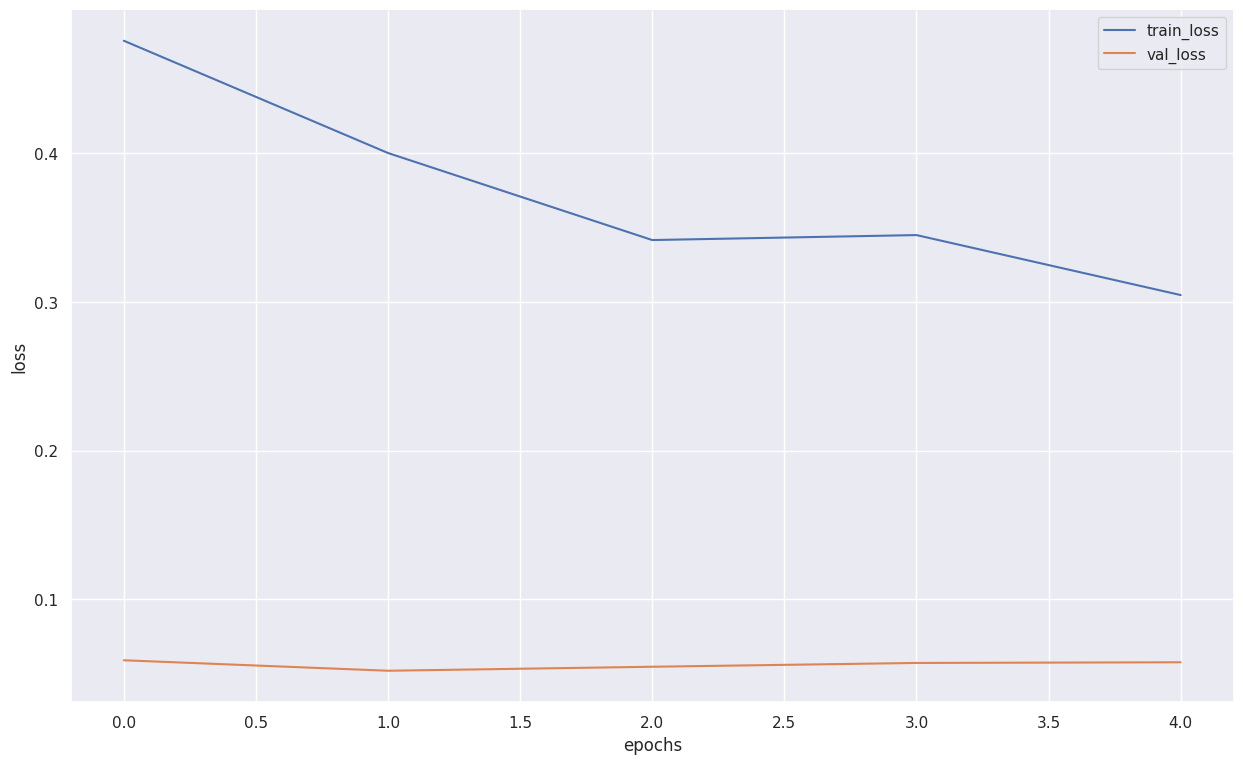

In [62]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label = "train_loss")
plt.plot(val_loss, label = "val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [63]:
# lets save weights of our model
torch.save(model_with_triplet_loss.state_dict(), "model_weights_trploss_m_1.pth")

In [64]:
print("Test accuracy: ", test_accuracy(test_loader, train_loader, model_with_triplet_loss))

Test accuracy:  0.0


### ArcFace Loss (Additive Angular Margin Loss) (2 points)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss. Again, you might use whatever architecture you prefer, including ImageNet pre-trained networks. Do not use pre-trained networks on any other dataset.

**To get the full mark for this task you need to train a model using TripletLoss correctly at least for one value of margin and achieve >=70% acc on test set.**

In [98]:
def nomralization(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

class Arcface(torch.nn.Module):
    def __init__(self, embedding_size=512, classnum=1000,  s=64., m=0.5):
        super(Arcface, self).__init__()
        self.classnum = classnum
        self.weights = torch.nn.Parameter(torch.Tensor(embedding_size,classnum))
        self.weights.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m
        self.s = s
    def forward(self, embbedings, label):

        weights_n = nomralization(self.weights,axis=0)

        cos_theta = torch.mm(embbedings, weights_n)

        cos_theta = cos_theta.clamp(-1,1)
        cos_theta_2 = torch.pow(cos_theta, 2)
        sin_theta_2 = 1 - cos_theta_2
        sin_theta = torch.sqrt(sin_theta_2)
        cos_theta_m = (cos_theta * math.cos(self.m) - sin_theta * math.sin(self.m))

        cond_v = cos_theta - math.cos(math.pi - self.m)
        cond_mask = cond_v <= 0
        keep_val = (cos_theta - self.m * math.sin(self.m))
        cos_theta_m[cond_mask] = keep_val[cond_mask]
        output = cos_theta * 1.0
        idx = torch.arange(0, len(embbedings), dtype=torch.long)
        output[idx, label] = cos_theta_m[idx, label]
        output *= self.s
        return output

In [99]:
train_data = celebADataset('train', transform)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

# choose your own batch_size
batch_size = 64
num_classes = 1000
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [100]:
def create_model(pretrained_model):
    cropped_model = torch.nn.Sequential(*(list(pretrained_model.children())[:-5]))
    for i, child in enumerate(cropped_model.children()):
        if i < 12:
            for param in child.parameters():
                param.requires_grad = False
        else:
            for param in child.parameters():
                param.requires_grad = True
    return cropped_model

In [101]:
def fit_epoch(model, opt, arc, criterion, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for batch in train_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        opt.zero_grad()

        embeddings = model(inputs).view(-1,21504)
        thetas = arc(embeddings, labels)
        loss = criterion(thetas, labels)

        loss.backward()
        opt.step()

        preds = torch.argmax(thetas, 1)

        running_corrects += torch.sum(preds == labels.data)
        running_loss += loss.item() * len(labels)
        processed_data += len(labels)

    scheduler.step()

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [102]:
def eval_epoch(model, arc, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for batch in val_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        with torch.set_grad_enabled(False):
            embeddings = model(inputs).view(-1,21504)
            thetas = arc(embeddings, labels)

            loss = criterion(thetas, labels)
            preds = torch.argmax(thetas, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [103]:
def train(model, opt, arc, criterion, scheduler, epochs=5):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, opt, arc, criterion, scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, arc, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

def test_accuracy(model, arc):
    model.eval()
    running_corrects = 0
    processed_size = 0
    for batch in test_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        with torch.set_grad_enabled(False):
            embeddings = model(inputs).view(-1,21504)
            thetas = arc(embeddings, labels)
            preds = torch.argmax(thetas, 1)

        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    test_acc = running_corrects.double() / processed_size
    return test_acc.item()

In [106]:
# https://disk.yandex.ru/d/TemSa0RPUe18_w
pretrained_model = torch.load('/content/model_weights2.pth', map_location = DEVICE)
model = torch.nn.DataParallel(create_model(pretrained_model).to(DEVICE))
criterion = torch.nn.CrossEntropyLoss()
arc = torch.nn.DataParallel(Arcface(embedding_size = 21504, classnum = 1000, s = 44, m = 3.5).to(DEVICE))
opt = torch.optim.Adam([{'params': model.parameters()}, {'params': arc.parameters()}], lr=0.00001, weight_decay=5e-3 )
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

In [107]:
history = train(model, opt, arc, criterion, scheduler, epochs = 5)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.052979516518222344


epoch:  20%|██        | 1/5 [00:45<03:03, 45.75s/it]


Epoch 001 train_loss: 0.0530     val_loss 0.0022 train_acc 0.9919 val_acc 0.9995
loss 0.009605441590121735


epoch:  40%|████      | 2/5 [01:28<02:12, 44.10s/it]


Epoch 002 train_loss: 0.0096     val_loss 0.0014 train_acc 0.9986 val_acc 0.9995
loss 0.010406454284857859


epoch:  60%|██████    | 3/5 [02:13<01:28, 44.50s/it]


Epoch 003 train_loss: 0.0104     val_loss 0.0032 train_acc 0.9982 val_acc 0.9989
loss 0.009300479895986247


epoch:  80%|████████  | 4/5 [02:58<00:44, 44.75s/it]


Epoch 004 train_loss: 0.0093     val_loss 0.0042 train_acc 0.9995 val_acc 0.9989
loss 0.2151437977229717


epoch: 100%|██████████| 5/5 [03:44<00:00, 44.92s/it]


Epoch 005 train_loss: 0.2151     val_loss 0.4198 train_acc 0.9934 val_acc 0.9931


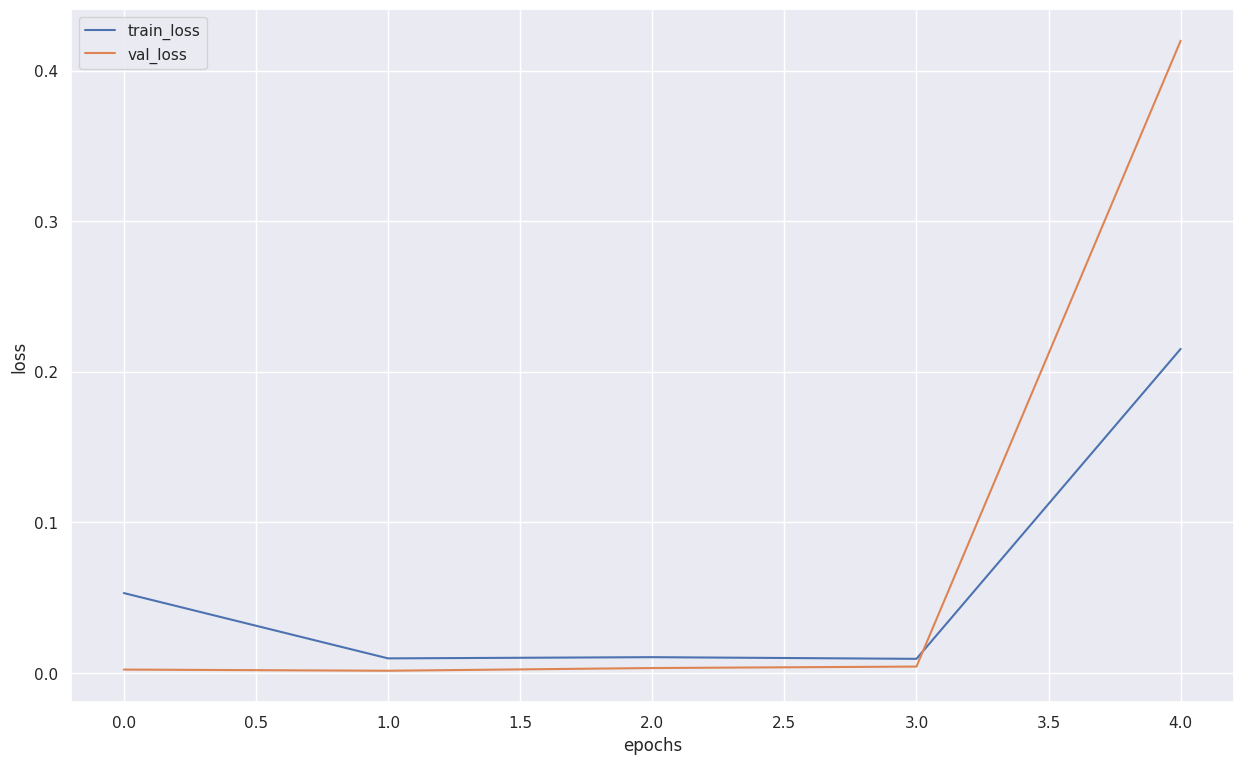

In [108]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label = "train_loss")
plt.plot(val_loss, label = "val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [109]:
test_acc = test_accuracy(model, arc)
print("Test accuracy: ", test_acc)

Test accuracy:  0.9955947136563877


## Bonus task (0.5 points): Finding trash photos

You have probably noticed that in identification rate calculation we use cosine similarity between embeddings, which includes embeddings' normalization. And in TripletLoss also we normalize embeddings before passing them to the loss. Actually this is how most of the face recognition algorithms work — they are designed to output a normalized embeddings and any comparison between embeddings is done after the embeddings are normalized. Sometimes it may be beneficial even to add a normalization layer (batchnorm or layernorm with fixed parameters) after the model's embedding layer to make the model output normalized embeddings.

But norms of the unnormalized embeddings can also be used. They can be used to detect trash photos — photos, where the face is presented really badly (e.g. back of the head instead of the forehead or even a photo without any head that has appeared in a dataset due to a mistake in face detection / landmarks detection algorithm).

Empirically it has been found that the higher the embedding's norm, the more the probability of the corresponding photo to be trash is.



**Task**: get the embeddings of photos in a test set / query set / distractors set. Sort them by their norms. Output the photos whose embeddings norms are the highest. Do they look like normal or trash?

**Doing this task will not give you points above 100% for the whole homework. But if you have any mistakes in previous sections, doing this task may give you additional points (5% of total points) to cover points lost.**

In [110]:
from facenet_pytorch import InceptionResnetV1
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 1000).to(DEVICE)
model.load_state_dict(torch.load("model_weights.pth", map_location = DEVICE))
model.logits = torch.nn.Identity()
model.last_bn = torch.nn.Identity()

In [111]:
import sys
def compute_embeddings(model, loader = None, images_type = None, images_list = None):
  all_embeddings = []
  model.eval()
  if loader != None:
      for batch in loader:
          inputs = batch['image'].to(DEVICE)
          with torch.set_grad_enabled(False):
              embeddings = model(inputs).to(DEVICE)
          for idx, val in enumerate(embeddings):
              all_embeddings.append((inputs[idx].cpu(), np.linalg.norm(np.array(val.flatten().cpu()))))
  else:
      path = './celebA_ir/celebA_query/' if images_type == 'query' else './celebA_ir/celebA_distractors/'
      for img_name in images_list:
          image = Image.open(path + img_name)
          with torch.set_grad_enabled(False):
              image = transform(image).to(DEVICE)
              outputs = (model(torch.unsqueeze(image, 0)).to(DEVICE))[0]
          all_embeddings.append((image.cpu(), np.linalg.norm(np.array(outputs.flatten().cpu()))))
          if sys.getsizeof(all_embeddings) > 8*1024*1024*1024:
              return all_embeddings

  return all_embeddings

### Check trash photos from test data

In [112]:
test_embeddings = compute_embeddings(model, test_loader)
test_embeddings = sorted(test_embeddings, key = lambda x: x[1])

Here photos with minimum value of norm in test data:

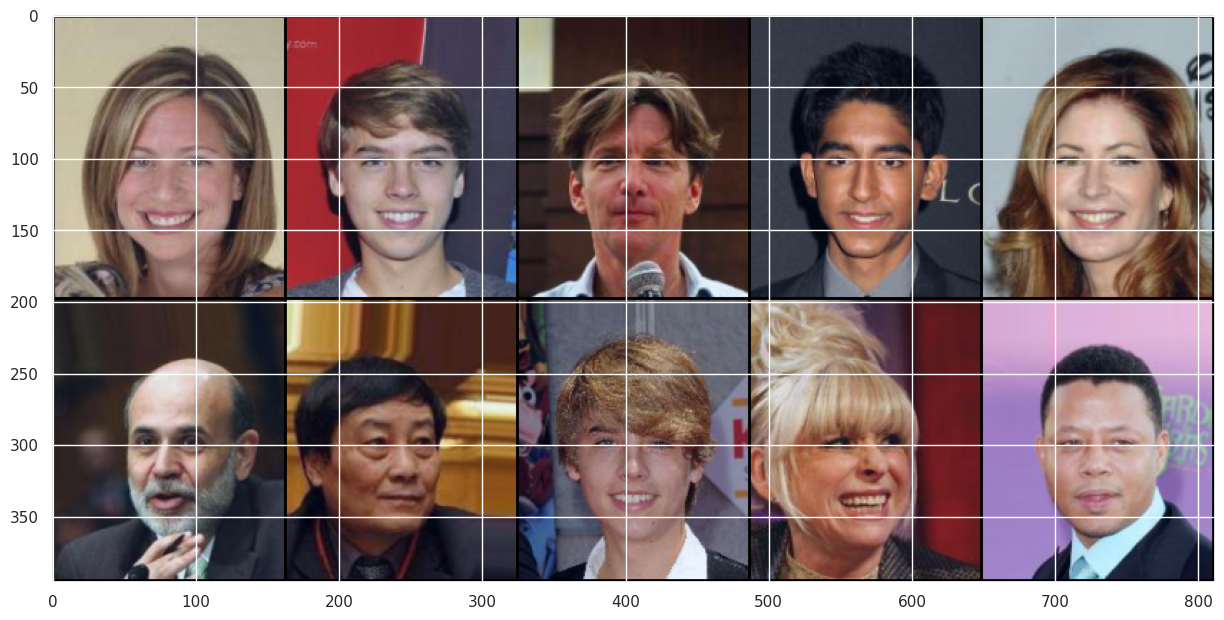

In [113]:
test_minimum = torchvision.utils.make_grid([ val[0] for val in test_embeddings[:10] ], nrow = 5, normalize=True, padding=2)
test_minimum = np.transpose(test_minimum, (1,2,0))
plt.figure(figsize=(15, 10))
plt.imshow(test_minimum)

Here photos with maximum value of norm in test data:

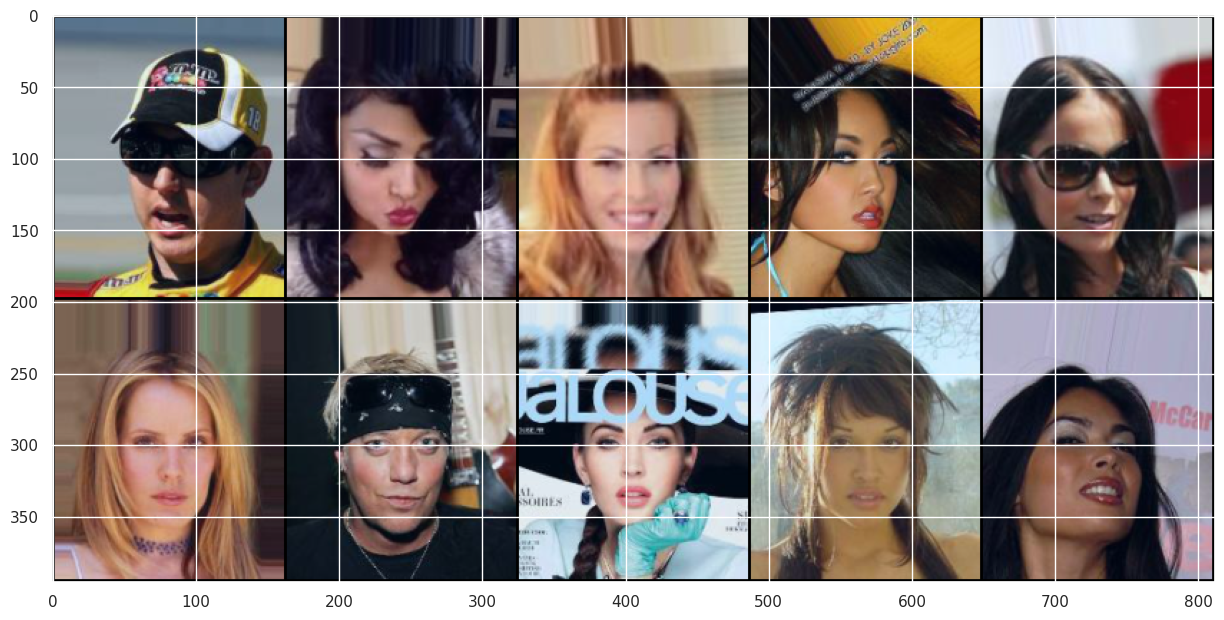

In [114]:
test_minimum = torchvision.utils.make_grid([ val[0] for val in test_embeddings[-10:]], nrow = 5, normalize=True, padding=2)
test_minimum = np.transpose(test_minimum, (1,2,0))
plt.figure(figsize=(15, 10))
plt.imshow(test_minimum)

### Check trash photos from query data

In [115]:
query_embeddings = compute_embeddings(model, images_type = 'query', images_list = query_img_names)
query_embeddings = sorted(query_embeddings, key = lambda x: x[1])

Here photos with minimum value of norm in query data:

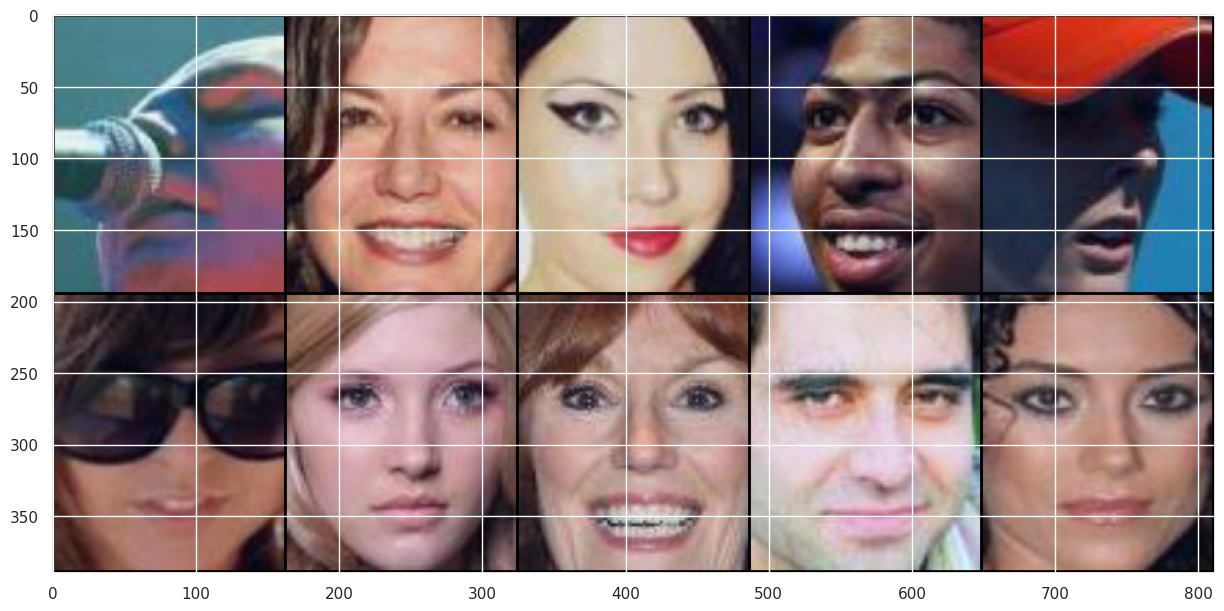

In [116]:
query_minimum = torchvision.utils.make_grid([ val[0] for val in query_embeddings[:10] ], nrow = 5, normalize=True, padding=2)
query_minimum = np.transpose(query_minimum, (1,2,0))
plt.figure(figsize=(15, 10))
plt.imshow(query_minimum)

Here photos with maximum value of norm in query data:

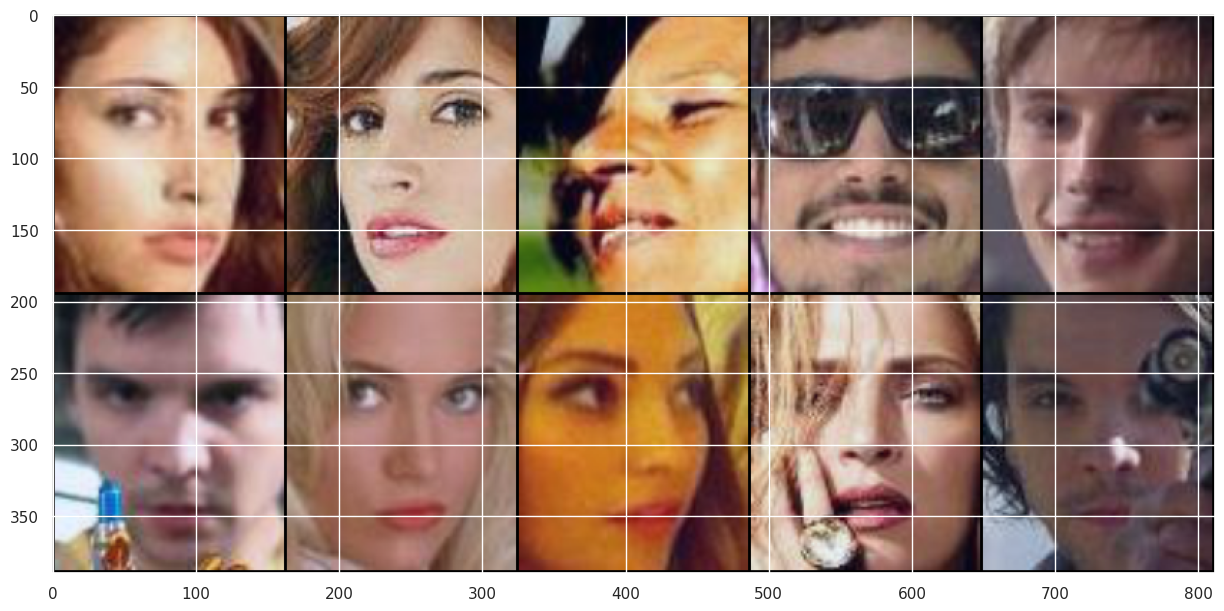

In [117]:
query_maximum = torchvision.utils.make_grid([ val[0] for val in query_embeddings[-10:] ], nrow = 5, normalize=True, padding=2)
query_maximum = np.transpose(query_maximum, (1,2,0))
plt.figure(figsize=(15, 10))
plt.imshow(query_maximum)

### Check trash photos from distractors data

In [118]:
distractors_embeddings = compute_embeddings(model, images_type = 'distractors', images_list = distractors_img_names)
distractors_embeddings = sorted(distractors_embeddings, key = lambda x: x[1])

Here photos with minimum value of norm in distractors data:

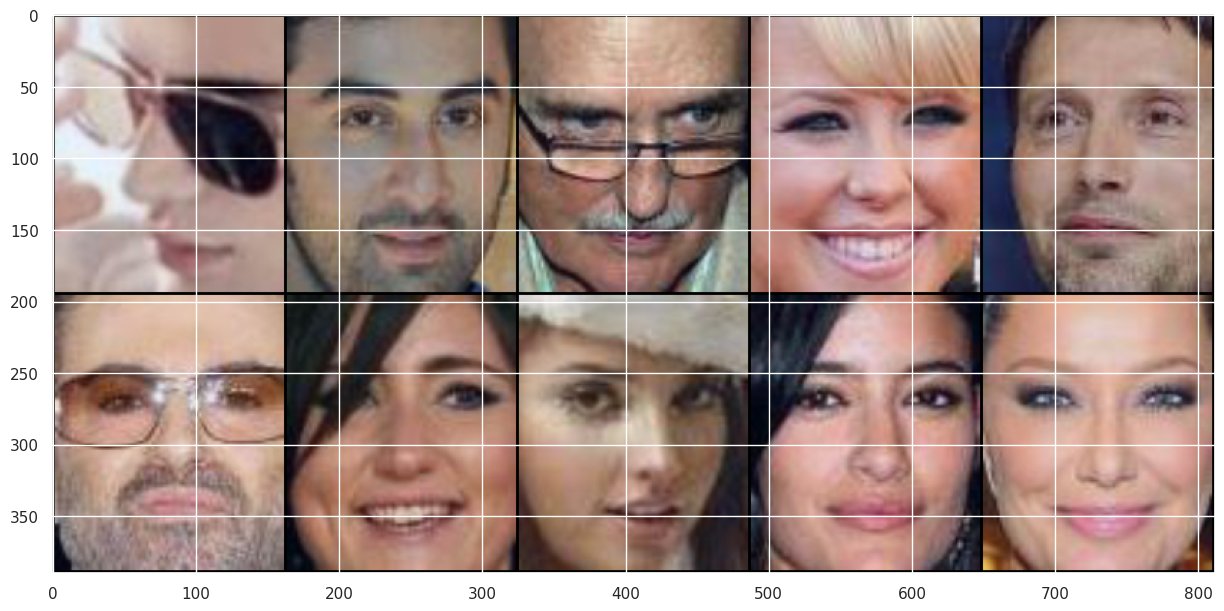

In [119]:
distractors_minimum = torchvision.utils.make_grid([ val[0] for val in distractors_embeddings[:10] ], nrow = 5, normalize=True, padding=2)
distractors_minimum = np.transpose(distractors_minimum, (1,2,0))
plt.figure(figsize=(15, 10))
plt.imshow(distractors_minimum)

Here photos with maximum value of norm in distractors data:

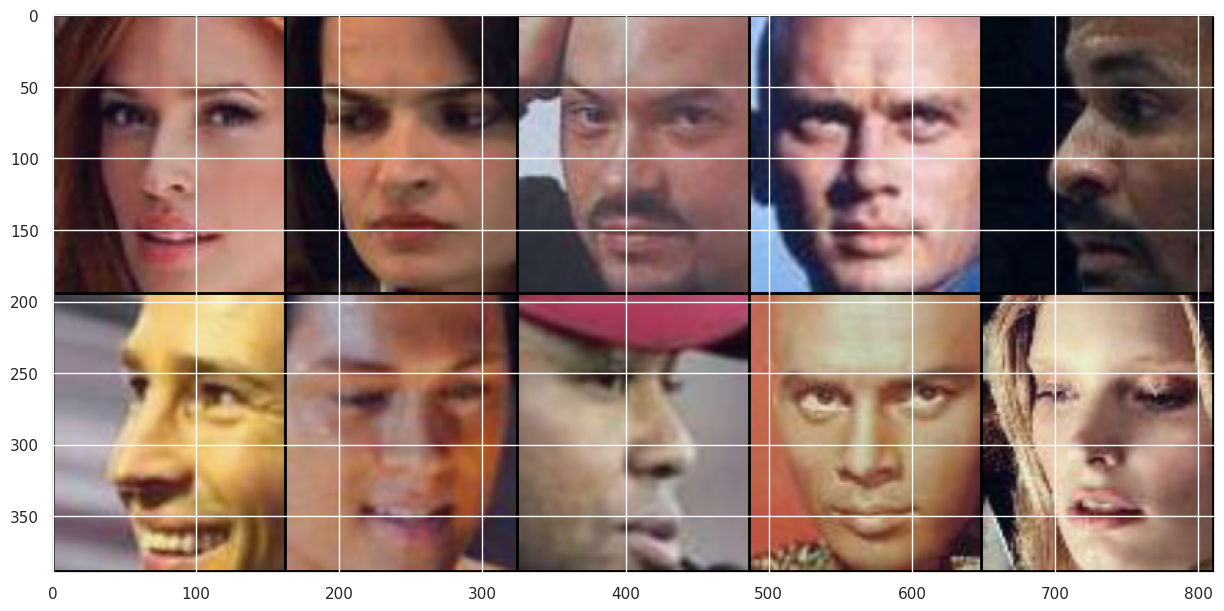

In [120]:
distractors_maximum = torchvision.utils.make_grid([ val[0] for val in distractors_embeddings[-10:] ], nrow = 5, normalize=True, padding=2)
distractors_maximum = np.transpose(distractors_maximum, (1,2,0))
plt.figure(figsize=(15, 10))
plt.imshow(distractors_maximum)

## What's next

What else can you do with this homework:
1. Try to train the network on faces which are aligned differently (or not aligned at all). The dataset [can be downloaded here](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ)
2. Try to mix different losses while training. This often helps.
3. Try other losses from [this](https://arxiv.org/pdf/1901.05903.pdf) paper
4. Train bigger model on bigger dataset, as whole celebA, add [LFW](http://vis-www.cs.umass.edu/lfw/) and other
5. Explore embeddings spaces you get out of different models. How well are embeddings clasterized? Are they evenly spreaded on the sphere? How could you suggest to make it better?